# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.941591,True,5.913060
1,1.445337,True,5.380751
2,0.585699,True,5.149434
3,1.076739,False,2.021763
4,-1.520760,False,-0.532469
...,...,...,...
995,0.744595,True,6.869821
996,-0.137876,False,-1.111942
997,-1.278868,False,0.288365
998,0.929446,True,5.555550


<AxesSubplot:xlabel='v0'>

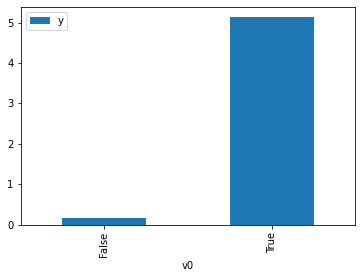

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

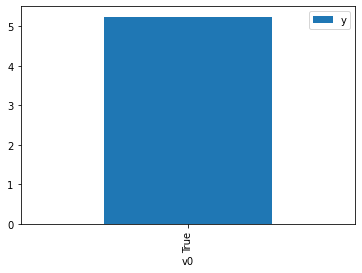

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.118007,False,1.590108,0.067099,14.903312
1,-0.354756,False,0.990830,0.673046,1.485782
2,1.494524,False,0.117046,0.029609,33.773465
3,-0.144071,False,-0.032810,0.560250,1.784919
4,1.118007,False,1.590108,0.067099,14.903312
...,...,...,...,...,...
995,-0.318083,False,-0.854877,0.654409,1.528097
996,1.494524,False,0.117046,0.029609,33.773465
997,1.095887,False,0.880985,0.070322,14.220238
998,-0.778031,False,-1.589359,0.843694,1.185264


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.302894,True,4.550083,0.954920,1.047208
1,-0.428836,True,5.060365,0.290964,3.436853
2,2.048998,True,6.975522,0.991443,1.008631
3,-1.163314,True,3.416153,0.071529,13.980311
4,1.217471,True,4.918229,0.945764,1.057346
...,...,...,...,...,...
995,0.329450,True,6.369552,0.697672,1.433337
996,1.081946,True,3.857809,0.927574,1.078082
997,0.728955,True,6.459965,0.851458,1.174455
998,-1.163314,True,3.416153,0.071529,13.980311


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              9010.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):                        0.00
Time:                        08:17:58   Log-Likelihood:                         -1446.8
No. Observations:                1000   AIC:                                      2898.
Df Residuals:                     998   BIC:                                      2907.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4618      0.039     11.759      0.000       0.385       0.539
x2             5.0295      0.054     93.741      0.000       4.924       5.135
==============================================================================
Omnibus:                        5.884   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.824
Skew:                           0.160   Prob(JB):                       0.0544
Kurtosis:                       3.193   Cond. No.                         2.34
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""